# Laptop Price Prediction
### This project was developed with an educational purpose. However, the main focus was on practicing machine learning engineering, so making the model as accurate as possible was not the main priority. 
The dataset was found at: https://www.kaggle.com/datasets/muhammetvarl/laptop-price

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from exploration import exploration as exp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import sklearn.metrics as metrics
import xgboost as xgb
import lightgbm as lgb

In [36]:
first_df = pd.read_csv("laptop_price.csv",  encoding='latin-1')
first_df.info()
first_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


laptop_ID Company      Product   TypeName  Inches  \
0          1   Apple  MacBook Pro  Ultrabook    13.3   
1          2   Apple  Macbook Air  Ultrabook    13.3   
2          3      HP       250 G6   Notebook    15.6   
3          4   Apple  MacBook Pro  Ultrabook    15.4   
4          5   Apple  MacBook Pro  Ultrabook    13.3   

                     ScreenResolution                         Cpu   Ram  \
0  IPS Panel Retina Display 2560x1600        Intel Core i5 2.3GHz   8GB   
1                            1440x900        Intel Core i5 1.8GHz   8GB   
2                   Full HD 1920x1080  Intel Core i5 7200U 2.5GHz   8GB   
3  IPS Panel Retina Display 2880x1800        Intel Core i7 2.7GHz  16GB   
4  IPS Panel Retina Display 2560x1600        Intel Core i5 3.1GHz   8GB   

                Memory                           Gpu  OpSys  Weight  \
0            128GB SSD  Intel Iris Plus Graphics 640  macOS  1.37kg   
1  128GB Flash Storage        Intel HD Graphics 6000  macOS  1.34kg   
2            256GB SSD         Intel HD Graphics 620  No OS  1.86kg   
3            512GB SSD            AMD Radeon Pro 455  macOS  1.83kg   
4            256GB SSD  Intel Iris Plus Graphics 650  macOS  1.37kg   

   Price_euros  
0      1339.69  
1       898.94  
2       575.00  
3      2537.45  
4      1803.60

In [37]:
first_df.describe(include="all")

laptop_ID Company Product  TypeName       Inches   ScreenResolution  \
count   1303.000000    1303    1303      1303  1303.000000               1303   
unique          NaN      19     618         6          NaN                 40   
top             NaN    Dell  XPS 13  Notebook          NaN  Full HD 1920x1080   
freq            NaN     297      30       727          NaN                507   
mean     660.155794     NaN     NaN       NaN    15.017191                NaN   
std      381.172104     NaN     NaN       NaN     1.426304                NaN   
min        1.000000     NaN     NaN       NaN    10.100000                NaN   
25%      331.500000     NaN     NaN       NaN    14.000000                NaN   
50%      659.000000     NaN     NaN       NaN    15.600000                NaN   
75%      990.500000     NaN     NaN       NaN    15.600000                NaN   
max     1320.000000     NaN     NaN       NaN    18.400000                NaN   

                               Cpu   Ram     Memory                    Gpu  \
count                         1303  1303       1303                   1303   
unique                         118     9         39                    110   
top     Intel Core i5 7200U 2.5GHz   8GB  256GB SSD  Intel HD Graphics 620   
freq                           190   619        412                    281   
mean                           NaN   NaN        NaN                    NaN   
std                            NaN   NaN        NaN                    NaN   
min                            NaN   NaN        NaN                    NaN   
25%                            NaN   NaN        NaN                    NaN   
50%                            NaN   NaN        NaN                    NaN   
75%                            NaN   NaN        NaN                    NaN   
max                            NaN   NaN        NaN                    NaN   

             OpSys Weight  Price_euros  
count         1303   1303  1303.000000  
unique           9    179          NaN  
top     Windows 10  2.2kg          NaN  
freq          1072    121          NaN  
mean           NaN    NaN  1123.686992  
std            NaN    NaN   699.009043  
min            NaN    NaN   174.000000  
25%            NaN    NaN   599.000000  
50%            NaN    NaN   977.000000  
75%            NaN    NaN  1487.880000  
max            NaN    NaN  6099.000000

In [38]:
first_profile = ProfileReport(first_df, title="First Dataset Report")
first_profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Cleaning
After carefully analyzing the raw data, I took some steps to make it more appropriate for modelling. 
- First I removed any duplicate or with values missing rows.
- After I split the CPU, GPU and Memory infomation into separate columns, to give the model more features to work with.
- Then I removed the columns that were not very correlated with the target variable, price. I also removed high cardinality columns, to avoid overfitting, like the Product column. 
- Some columns were renamed to facilitate handling the dataset.
- Lastly, the continuous variables were transformed into real number data. 

In [39]:
first_df.drop_duplicates(inplace=True)
first_df.dropna(inplace=True)
first_df["cpu_brand"] = first_df.apply(lambda x: x.Cpu.split(" ")[0], axis=1)
first_df["cpu_model"] = first_df.apply(lambda x: " ".join(x.Cpu.split(" ")[1:-1]), axis=1)
first_df["cpu_clock"] = first_df.apply(lambda x: x.Cpu.split(" ")[-1], axis=1)
first_df["gpu_brand"] = first_df.apply(lambda x: x.Gpu.split(" ")[0], axis=1)
first_df["gpu_model"] = first_df.apply(lambda x: " ".join(x.Gpu.split(" ")[1:]), axis=1)
first_df["disk_size"] = first_df.apply(lambda x: x.Memory.split(" ")[0], axis=1)
first_df["disk_type"] = first_df.apply(lambda x: " ".join(x.Memory.split(" ")[1:]), axis=1)
todrop_fst= ['laptop_ID', 'Product', 'TypeName','ScreenResolution', 'Cpu', 'Gpu', 'Memory']
first_df = exp.remove_columns(first_df, todrop_fst)
first_df.rename(columns={"Company" : "brand", "Product" : "model", "Inches" : "screen_size",  "Ram" : "memory",  "OpSys" : "os", "Weight" : "weight", "Price_euros" : "price"}, inplace=True)
first_df["disk_size"] = first_df.apply(lambda x: x.disk_size[:-2], axis=1)
first_df["cpu_clock"] = first_df.apply(lambda x: x.cpu_clock[:-3], axis=1)
first_df["weight"] = first_df.apply(lambda x: x.weight[:-2], axis=1)
first_df["memory"] = first_df.apply(lambda x: x.memory[:-2], axis=1)
to_number = ['screen_size', 'memory', 'weight', 'price', 'cpu_clock', 'disk_size']
first_df = exp.transform_column_type(first_df, to_number, "float")

## Data Modelling
With the data ready to go, it is now time to encode the categorical variables and start to test some models.

In [40]:
df_first_model = pd.get_dummies(first_df)
df_first_model.columns = df_first_model.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))

In [41]:
corrs = df_first_model.corr()['price'].abs()
columns = corrs[corrs > .1].index
corrs = corrs.filter(columns)
corrs

memory                               0.743007
weight                               0.210370
price                                1.000000
cpu_clock                            0.430293
disk_size                            0.298177
brand_Acer                           0.208349
brand_MSI                            0.180100
brand_Razer                          0.233756
os_Chrome OS                         0.118684
os_Linux                             0.162060
os_No OS                             0.177094
os_Windows 10                        0.137048
os_Windows 7                         0.152381
cpu_brand_AMD                        0.180111
cpu_brand_Intel                      0.181127
cpu_model_Celeron Dual Core N3050    0.105541
cpu_model_Celeron Dual Core N3060    0.177974
cpu_model_Celeron Dual Core N3350    0.184901
cpu_model_Core i3 6006U              0.232527
cpu_model_Core i3 7100U              0.130080
cpu_model_Core i5 7200U              0.121960
cpu_model_Core i7                 

In [42]:
x = df_first_model.drop(columns=['price'])
y = df_first_model['price']

In [43]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, random_state=42)

In [44]:
lr= LinearRegression()
lr.fit(train_x, train_y)
lr.score(test_x, test_y)

-1.8993089265661248e+17

In [45]:
pred_y = lr.predict(test_x)
pred = pred_y[:10]
test = test_y[:10].values[:10]
for item in range(10):
    print("Prediction: {} - Real value: {}".format(pred[item], test[item]))

Prediction: 1288.95654296875 - Real value: 1672.0
Prediction: 1238.54931640625 - Real value: 1149.0
Prediction: -115866240296.27368 - Real value: 499.0
Prediction: 977.31103515625 - Real value: 899.0
Prediction: 1026.87548828125 - Real value: 1244.0
Prediction: 1226.508056640625 - Real value: 1398.99
Prediction: 766.4560546875 - Real value: 719.0
Prediction: 444.601806640625 - Real value: 459.0
Prediction: 1117.43408203125 - Real value: 1191.0
Prediction: 433.260498046875 - Real value: 349.0


In [46]:
mse = metrics.mean_squared_error(test_y, pred_y)
rmse = metrics.mean_squared_error(test_y, pred_y, squared=False)
print("Mean Squared Error {}".format(mse))
print("Rooted Mean Squared Error {}".format(rmse))

Mean Squared Error 1.010120213190824e+23
Rooted Mean Squared Error 317823884123.0822


In [47]:
clf= Lasso()
clf.fit(train_x, train_y)
clf.score(test_x, test_y)

0.7679698133023287

In [48]:
pred_y = clf.predict(test_x)
pred = pred_y[:10]
test = test_y[:10].values[:10]
for item in range(10):
    print("Prediction: {} - Real value: {}".format(pred[item], test[item]))

Prediction: 1241.8704193080384 - Real value: 1672.0
Prediction: 1240.727447987364 - Real value: 1149.0
Prediction: 403.02137798566537 - Real value: 499.0
Prediction: 1037.9842194908827 - Real value: 899.0
Prediction: 997.5204572146275 - Real value: 1244.0
Prediction: 1228.2158081675498 - Real value: 1398.99
Prediction: 783.5281773728942 - Real value: 719.0
Prediction: 555.30342129349 - Real value: 459.0
Prediction: 1174.3787451170701 - Real value: 1191.0
Prediction: 146.27664134051926 - Real value: 349.0


In [49]:
mse = metrics.mean_squared_error(test_y, pred_y)
rmse = metrics.mean_squared_error(test_y, pred_y, squared=False)
print("Mean Squared Error {}".format(mse))
print("Rooted Mean Squared Error {}".format(rmse))

Mean Squared Error 123401.92707750032
Rooted Mean Squared Error 351.2861043045972


/home/penelope/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


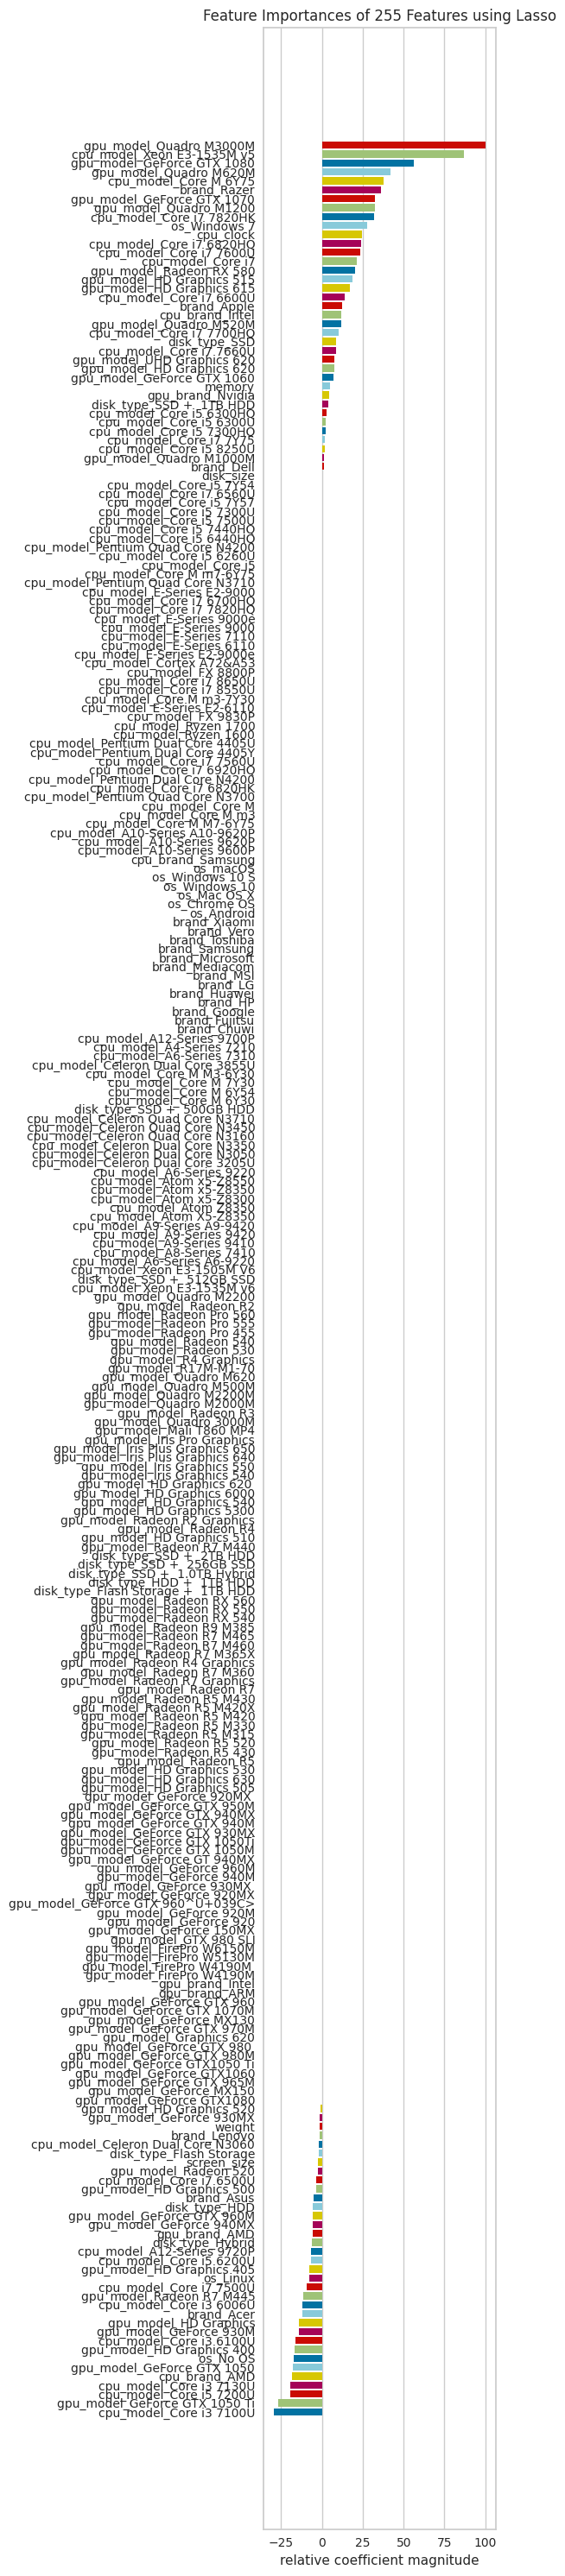

<AxesSubplot:title={'center':'Feature Importances of 255 Features using Lasso'}, xlabel='relative coefficient magnitude'>

In [50]:
from yellowbrick.features import FeatureImportances
fig, ax = plt.subplots(figsize=(6, 30))
fi_viz = FeatureImportances(clf, labels=train_x.columns)
fi_viz.fit(train_x, train_y)
fi_viz.poof()

In [51]:
train_x.columns[train_x.columns.str.contains("[\[\]<]")]

Index([], dtype='object')

In [52]:
xgr = xgb.XGBRegressor()
xgr.fit(train_x, train_y)
xgr.score(test_x, test_y)

0.8194276279862555

In [53]:
pred_y = xgr.predict(test_x)
pred = pred_y[:10]
test = test_y[:10].values[:10]
for item in range(10):
    print("Prediction: {} - Real value: {}".format(pred[item], test[item]))

Prediction: 1477.150146484375 - Real value: 1672.0
Prediction: 1772.366455078125 - Real value: 1149.0
Prediction: 515.8364868164062 - Real value: 499.0
Prediction: 860.0459594726562 - Real value: 899.0
Prediction: 1389.1741943359375 - Real value: 1244.0
Prediction: 1514.4781494140625 - Real value: 1398.99
Prediction: 736.13037109375 - Real value: 719.0
Prediction: 473.104248046875 - Real value: 459.0
Prediction: 1331.644287109375 - Real value: 1191.0
Prediction: 325.1271667480469 - Real value: 349.0


In [54]:
mse = metrics.mean_squared_error(test_y, pred_y)
rmse = metrics.mean_squared_error(test_y, pred_y, squared=False)
print("Mean Squared Error {}".format(mse))
print("Rooted Mean Squared Error {}".format(rmse))

Mean Squared Error 96034.82633268513
Rooted Mean Squared Error 309.89486335317844


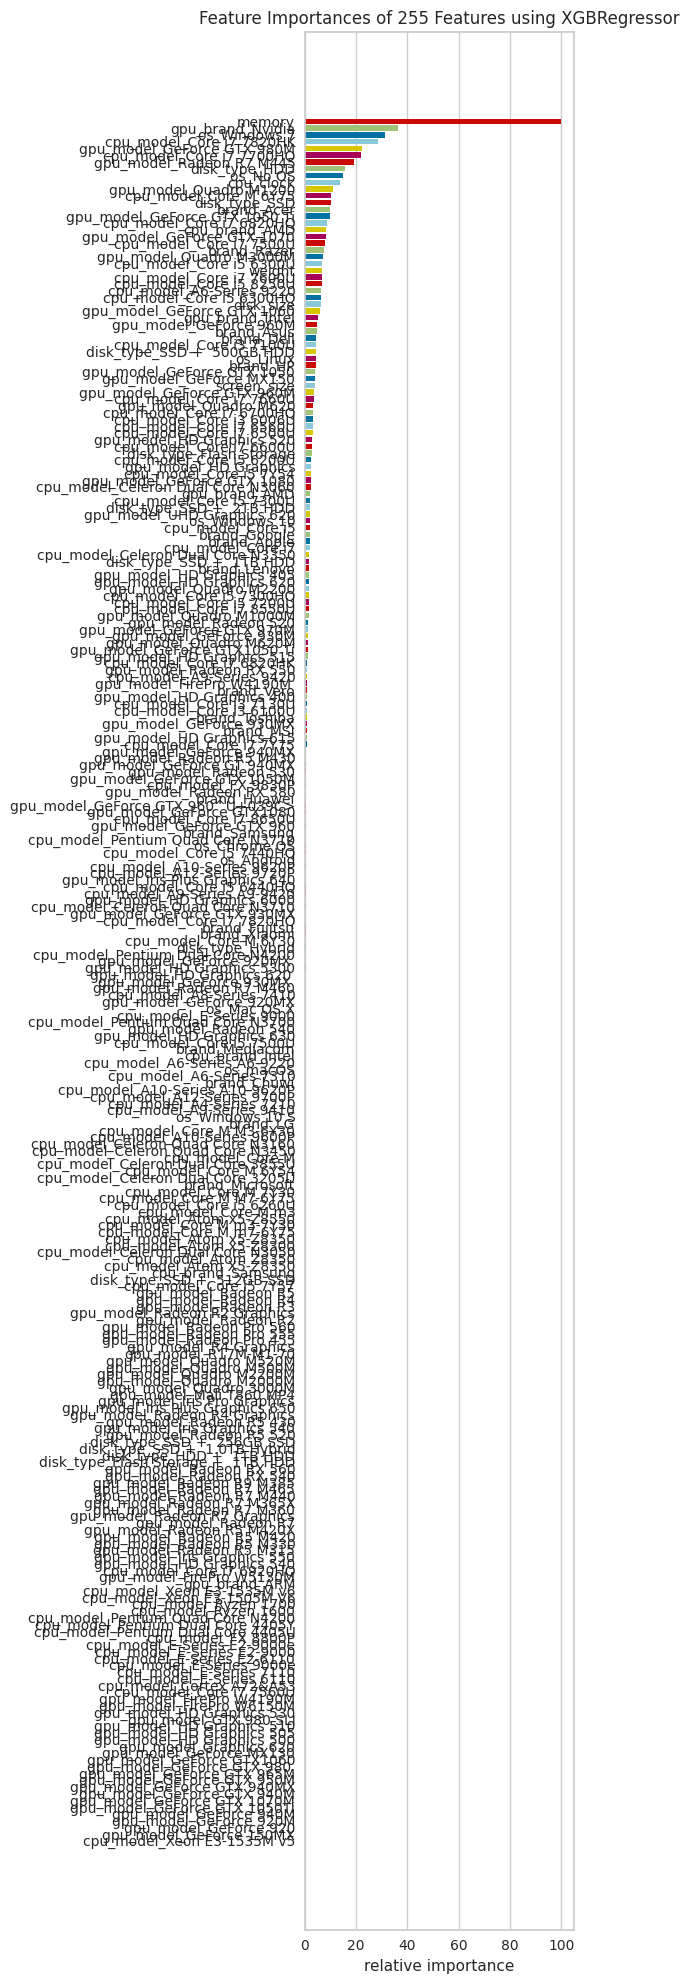

<AxesSubplot:title={'center':'Feature Importances of 255 Features using XGBRegressor'}, xlabel='relative importance'>

In [55]:
fig, ax = plt.subplots(figsize=(6, 20))
fi_viz = FeatureImportances(xgr, labels=train_x.columns)
fi_viz.fit(train_x, train_y)
fi_viz.poof()

In [56]:
lgr = lgb.LGBMRegressor()
lgr.fit(train_x, train_y)
lgr.score(test_x, test_y)


0.7898260655912519

## Results
After some tests, the most performant model was the XGBRegressor, with an R² of 82%. For its purpose, I found the accuracy to be quite satifactory. For the next steps of the project, my goal is to take it to production on the cloud, and use the dataset below, a diffrent one, to simulate an architecture for retraining. 

In [57]:
second_df = pd.read_csv("Cleaned_Laptop_data.csv")
second_df.info()
second_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            896 non-null    object 
 1   model            896 non-null    object 
 2   processor_brand  896 non-null    object 
 3   processor_name   896 non-null    object 
 4   processor_gnrtn  896 non-null    object 
 5   ram_gb           896 non-null    object 
 6   ram_type         896 non-null    object 
 7   ssd              896 non-null    object 
 8   hdd              896 non-null    object 
 9   os               896 non-null    object 
 10  os_bit           896 non-null    object 
 11  graphic_card_gb  896 non-null    int64  
 12  weight           896 non-null    object 
 13  display_size     896 non-null    object 
 14  warranty         896 non-null    int64  
 15  Touchscreen      896 non-null    object 
 16  msoffice         896 non-null    object 
 17  latest_price    

brand    model processor_brand     processor_name processor_gnrtn  \
0  Lenovo  A6-9225             AMD  A6-9225 Processor            10th   
1  Lenovo  Ideapad             AMD           APU Dual            10th   
2   Avita     PURA             AMD           APU Dual            10th   
3   Avita     PURA             AMD           APU Dual            10th   
4   Avita     PURA             AMD           APU Dual            10th   

    ram_gb ram_type     ssd      hdd       os  ... display_size  warranty  \
0  4 GB GB     DDR4    0 GB  1024 GB  Windows  ...      Missing         0   
1  4 GB GB     DDR4    0 GB   512 GB  Windows  ...      Missing         0   
2  4 GB GB     DDR4  128 GB     0 GB  Windows  ...      Missing         0   
3  4 GB GB     DDR4  128 GB     0 GB  Windows  ...      Missing         0   
4  4 GB GB     DDR4  256 GB     0 GB  Windows  ...      Missing         0   

  Touchscreen msoffice  latest_price old_price discount  star_rating  ratings  \
0          No       No         24990     32790       23          3.7       63   
1          No       No         19590     21325        8          3.6     1894   
2          No       No         19990     27990       28          3.7     1153   
3          No       No         21490     27990       23          3.7     1153   
4          No       No         24990     33490       25          3.7     1657   

   reviews  
0       12  
1      256  
2      159  
3      159  
4      234  

[5 rows x 23 columns]

In [58]:
second_df.describe(include="all")

brand    model processor_brand processor_name processor_gnrtn   ram_gb  \
count    896      896             896            896             896      896   
unique    21      117               5             28               8        4   
top     ASUS  Missing           Intel        Core i5            11th  8 GB GB   
freq     254       95             660            312             346      454   
mean     NaN      NaN             NaN            NaN             NaN      NaN   
std      NaN      NaN             NaN            NaN             NaN      NaN   
min      NaN      NaN             NaN            NaN             NaN      NaN   
25%      NaN      NaN             NaN            NaN             NaN      NaN   
50%      NaN      NaN             NaN            NaN             NaN      NaN   
75%      NaN      NaN             NaN            NaN             NaN      NaN   
max      NaN      NaN             NaN            NaN             NaN      NaN   

       ram_type     ssd   hdd       os  ... display_size    warranty  \
count       896     896   896      896  ...          896  896.000000   
unique        6       8     4        3  ...           16         NaN   
top        DDR4  512 GB  0 GB  Windows  ...      Missing         NaN   
freq        760     417   666      832  ...          332         NaN   
mean        NaN     NaN   NaN      NaN  ...          NaN    0.691964   
std         NaN     NaN   NaN      NaN  ...          NaN    0.606282   
min         NaN     NaN   NaN      NaN  ...          NaN    0.000000   
25%         NaN     NaN   NaN      NaN  ...          NaN    0.000000   
50%         NaN     NaN   NaN      NaN  ...          NaN    1.000000   
75%         NaN     NaN   NaN      NaN  ...          NaN    1.000000   
max         NaN     NaN   NaN      NaN  ...          NaN    3.000000   

       Touchscreen msoffice   latest_price      old_price    discount  \
count          896      896     896.000000     896.000000  896.000000   
unique           2        2            NaN            NaN         NaN   
top             No       No            NaN            NaN         NaN   
freq           793      606            NaN            NaN         NaN   
mean           NaN      NaN   76309.860491   88134.154018   18.527902   
std            NaN      NaN   46613.354368   55719.645554   10.508486   
min            NaN      NaN   13990.000000       0.000000    0.000000   
25%            NaN      NaN   45490.000000   54940.500000   11.000000   
50%            NaN      NaN   63494.000000   78052.500000   19.000000   
75%            NaN      NaN   89090.000000  111019.500000   26.000000   
max            NaN      NaN  441990.000000  377798.000000   57.000000   

        star_rating       ratings      reviews  
count    896.000000    896.000000   896.000000  
unique          NaN           NaN          NaN  
top             NaN           NaN          NaN  
freq            NaN           NaN          NaN  
mean       2.980469    367.391741    46.152902  
std        1.965254   1106.309355   136.079586  
min        0.000000      0.000000     0.000000  
25%        0.000000      0.000000     0.000000  
50%        4.100000     19.000000     3.000000  
75%        4.400000    179.500000    23.250000  
max        5.000000  15279.000000  1947.000000  

[11 rows x 23 columns]

In [59]:
todrop_snd= ['index','ram_type', 'os_bit', 'warranty', 'Touchscreen', 'msoffice', 'discount', 'star_rating', 'ratings', 'reviews', 'weight']
second_df = exp.remove_columns(second_df, todrop_snd)
second_df.drop_duplicates(inplace=True)
second_df.dropna(inplace=True)
second_df["ram_gb"] = second_df.apply(lambda x: x.ram_gb.split(" ")[0], axis=1)
second_df["ssd"] = second_df.apply(lambda x: x.ssd.split(" ")[0], axis=1)
second_df["hdd"] = second_df.apply(lambda x: x.hdd.split(" ")[0], axis=1)
second_df["old_price"] = second_df.apply(lambda x: x.old_price * 0.013, axis=1)
second_df["latest_price"] = second_df.apply(lambda x: x.latest_price * 0.013, axis=1)
#second_df = exp.transform_column_type(second_df, ['brand', 'model', 'processor_brand', 'processor_name', 'processor_gnrtn', 'os'], 'str')
#second_df = exp.lowercase_values(second_df, ['brand', 'model', 'processor_brand', 'processor_name', 'processor_gnrtn', 'os'])


In [60]:
second_profile = ProfileReport(second_df, title="Second Dataset Report")
second_profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### To Do:
- Remove unnecessary columns ✅
- Drop duplicate rows ✅
- Convert currency 
- Make ram and disk size uniform ✅
- Lowercase all text
- Change missing to null
- Deal with null data